# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci697l.github.io/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from asgn1.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from asgn1.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each row is the concatenation of all feature vectors for a single image.

In [3]:
from asgn1.features import *

num_color_bins = 20 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from asgn1.classifiers.linear_classifier import LinearSVM

X_train_feats=np.array(X_train_feats)
X_val_feats=np.array(X_val_feats)

learning_rates = [1e-8, 1e-7,1e-6]
regularization_strengths = [1e4,1e5,5e5,1e6]

results = {}
best_val = -1
best_svm = None
for i in learning_rates:
    for j in regularization_strengths:
        svm=LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=i, reg=j,
                      num_iters=2000, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        results[i,j]=[np.mean(y_train == y_train_pred),np.mean(y_val == y_val_pred)]
        print np.mean(y_val == y_val_pred)
        if (np.mean(y_val == y_val_pred))>best_val:
            best_val=np.mean(y_val == y_val_pred)
            best_svm=svm

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 2000: loss 16.883930
iteration 100 / 2000: loss 16.726866
iteration 200 / 2000: loss 16.569927
iteration 300 / 2000: loss 16.417953
iteration 400 / 2000: loss 16.283468
iteration 500 / 2000: loss 16.136481
iteration 600 / 2000: loss 15.980465
iteration 700 / 2000: loss 15.841056
iteration 800 / 2000: loss 15.712223
iteration 900 / 2000: loss 15.577260
iteration 1000 / 2000: loss 15.460683
iteration 1100 / 2000: loss 15.323662
iteration 1200 / 2000: loss 15.193724
iteration 1300 / 2000: loss 15.091841
iteration 1400 / 2000: loss 14.949342
iteration 1500 / 2000: loss 14.834043
iteration 1600 / 2000: loss 14.716241
iteration 1700 / 2000: loss 14.598590
iteration 1800 / 2000: loss 14.501268
iteration 1900 / 2000: loss 14.392554
0.118
iteration 0 / 2000: loss 93.381842
iteration 100 / 2000: loss 78.106735
iteration 200 / 2000: loss 65.552936
iteration 300 / 2000: loss 55.306249
iteration 400 / 2000: loss 46.907264
iteration 500 / 2000: loss 40.022681
iteration 600 / 2000: loss

iteration 500 / 2000: loss 8.999997
iteration 600 / 2000: loss 9.000006
iteration 700 / 2000: loss 9.000009
iteration 800 / 2000: loss 9.000004
iteration 900 / 2000: loss 8.999993
iteration 1000 / 2000: loss 8.999996
iteration 1100 / 2000: loss 9.000004
iteration 1200 / 2000: loss 8.999987
iteration 1300 / 2000: loss 9.000005
iteration 1400 / 2000: loss 9.000014
iteration 1500 / 2000: loss 9.000003
iteration 1600 / 2000: loss 8.999998
iteration 1700 / 2000: loss 9.000000
iteration 1800 / 2000: loss 8.999995
iteration 1900 / 2000: loss 8.999996
0.34
lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.110265 val accuracy: 0.118000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.103633 val accuracy: 0.101000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.422224 val accuracy: 0.428000
lr 1.000000e-08 reg 1.000000e+06 train accuracy: 0.421673 val accuracy: 0.427000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.161898 val accuracy: 0.170000
lr 1.000000e-07 reg 1.000000e+05 train a

In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(np.array(X_test_feats))
num_classes=10
confmatrix = np.zeros((num_classes,num_classes))
for i in range(0,y_test_pred.shape[0]):
    confmatrix[y_test[i],y_test_pred[i]]+=1
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.421


In [7]:
import pickle
pickle.dump({"best_svm":best_svm,"cmatrix":confmatrix}, open( "best_svm_HOG.p", "wb" ) )

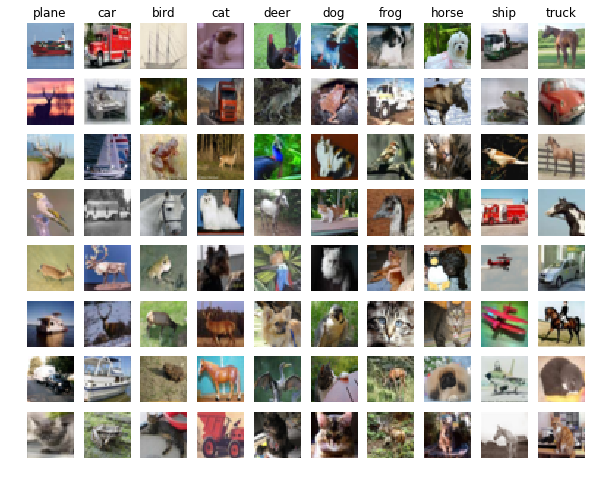

In [8]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Since we are considering the color histogram feature, the background of the object comes to play. Hence in many images birds and animals are confused with the green background which normally a deer in forest has. Edge features also get higighted in HOG hence all vehicles like truck, car, van are prone to misclassification.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [9]:
print X_train_feats.shape

(49000, 165)


In [10]:
from asgn1.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
print input_dim
hidden_dim = 70
num_classes = 10
learning_rates=[2e-1,3e-1,5e-1]
regularization_strengths = [0.0005,0.002,0.003,0.005,0.01]
best_val=-1
results={}
best_net = None
input_size = 32 * 32 * 3
for i in learning_rates:
    for j in regularization_strengths:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                                num_iters=1600,batch_size=200,
                                learning_rate=i, learning_rate_decay=0.95,
                                    reg=j, verbose=True)
        y_train_pred = net.predict(X_train_feats)
        y_val_pred = net.predict(X_val_feats)
        results[i,j]=[np.mean(y_train == y_train_pred),np.mean(y_val == y_val_pred)]
        print np.mean(y_val == y_val_pred)
        if (np.mean(y_val == y_val_pred))>best_val:
            best_val=np.mean(y_val == y_val_pred)
            best_net=net
print best_val
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val


165
iteration 0 / 1600: loss 2.302585
iteration 100 / 1600: loss 2.251257
iteration 200 / 1600: loss 1.682294
iteration 300 / 1600: loss 1.386192
iteration 400 / 1600: loss 1.387858
iteration 500 / 1600: loss 1.233721
iteration 600 / 1600: loss 1.446833
iteration 700 / 1600: loss 1.401768
iteration 800 / 1600: loss 1.354188
iteration 900 / 1600: loss 1.362995
iteration 1000 / 1600: loss 1.249251
iteration 1100 / 1600: loss 1.171859
iteration 1200 / 1600: loss 1.207694
iteration 1300 / 1600: loss 1.319721
iteration 1400 / 1600: loss 1.434774
iteration 1500 / 1600: loss 1.266946
0.555
iteration 0 / 1600: loss 2.302585
iteration 100 / 1600: loss 2.232330
iteration 200 / 1600: loss 1.627897
iteration 300 / 1600: loss 1.473304
iteration 400 / 1600: loss 1.341041
iteration 500 / 1600: loss 1.555978
iteration 600 / 1600: loss 1.281960
iteration 700 / 1600: loss 1.474045
iteration 800 / 1600: loss 1.356878
iteration 900 / 1600: loss 1.218858
iteration 1000 / 1600: loss 1.132982
iteration 1100 

0.575
iteration 0 / 1600: loss 2.302586
iteration 100 / 1600: loss 1.729639
iteration 200 / 1600: loss 1.572397
iteration 300 / 1600: loss 1.497614
iteration 400 / 1600: loss 1.477036
iteration 500 / 1600: loss 1.466432
iteration 600 / 1600: loss 1.525809
iteration 700 / 1600: loss 1.614458
iteration 800 / 1600: loss 1.501544
iteration 900 / 1600: loss 1.467053
iteration 1000 / 1600: loss 1.614648
iteration 1100 / 1600: loss 1.381399
iteration 1200 / 1600: loss 1.365789
iteration 1300 / 1600: loss 1.441970
iteration 1400 / 1600: loss 1.484217
iteration 1500 / 1600: loss 1.531225
0.52
0.575
lr 2.000000e-01 reg 5.000000e-04 train accuracy: 0.581102 val accuracy: 0.555000
lr 2.000000e-01 reg 2.000000e-03 train accuracy: 0.574633 val accuracy: 0.561000
lr 2.000000e-01 reg 3.000000e-03 train accuracy: 0.572735 val accuracy: 0.553000
lr 2.000000e-01 reg 5.000000e-03 train accuracy: 0.564347 val accuracy: 0.542000
lr 2.000000e-01 reg 1.000000e-02 train accuracy: 0.545816 val accuracy: 0.55200

In [13]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.
y_test_pred = best_net.predict(np.array(X_test_feats))
confmatrix = np.zeros((num_classes,num_classes))
for i in range(0,y_test_pred.shape[0]):
    confmatrix[y_test[i],y_test_pred[i]]+=1
test_acc = np.mean(y_test == y_test_pred)
print test_acc

0.543


In [14]:
import pickle
pickle.dump({"best_net":best_net,"cmatrix":confmatrix}, open( "best_net_HOG.p", "wb" ) )

# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

In [ ]:
#Please visit features(dSIFT).ipynb for this implementation

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!

In [ ]:
#please visit Bonus.ipnyb for some insights into the efficiency of these models